In [136]:
import pandas as pd 
import geopandas as gp
import os 
import json
from dotenv import load_dotenv
load_dotenv()


True

In [137]:
with open("./data/pen_portraits.json") as f:
    sig_descriptions = json.load(f)

In [17]:
signatures = gp.read_file("./data/spatial_signatures_GB.gpkg")

In [68]:
regions = gp.read_file("./data/counties.geojson")

In [85]:
regions["name"] = [val[0] for val in regions["ctyua_name"].values]

In [106]:
regions = regions.to_crs("EPSG:4326")
signatures = signatures.to_crs("EPSG:4326")

In [115]:
sig_types = signatures["type"].value_counts()


In [131]:
regions

,geo_point_2d,year,ctry_code,ctry_name,rgn_code,rgn_name,ctyua_code,ctyua_name,ctyua_area_code,ctyua_type,geometry,name
0,"{'lon': -1.966260152807215, 'lat': 52.59924081...",2022,[E92000001],[England],[E12000005],[West Midlands],[E08000030],[Walsall],GBR,metropolitan district,"POLYGON ((-1.87257 52.58493, -1.87549 52.58585...",Walsall
1,"{'lon': -1.8789397607334983, 'lat': 50.7495754...",2022,[E92000001],[England],[E12000009],[South West],[E06000058],"[Bournemouth, Christchurch and Poole]",GBR,unitary authority,"MULTIPOLYGON (((-2.00021 50.73032, -2.00297 50...",Bournemouth
2,"{'lon': -2.119264589844318, 'lat': 51.82752090...",2022,[E92000001],[England],[E12000009],[South West],[E10000013],[Gloucestershire],GBR,county,"POLYGON ((-1.66577 51.98748, -1.66929 51.98921...",Gloucestershire
3,"{'lon': -2.6308440365947634, 'lat': 57.2414618...",2022,[S92000003],[Scotland],[S92000003],[Scotland],[S12000034],[Aberdeenshire],GBR,council area,"POLYGON ((-2.06138 57.21195, -2.05864 57.21801...",Aberdeenshire
4,"{'lon': -0.15743534194660444, 'lat': 51.546422...",2022,[E92000001],[England],[E12000007],[London],[E09000007],[Camden],GBR,London borough,"POLYGON ((-0.14242 51.56912, -0.15035 51.57157...",Camden
...,...,...,...,...,...,...,...,...,...,...,...,...
212,"{'lon': -2.128086076696361, 'lat': 53.39390485...",2022,[E92000001],[England],[E12000002],[North West],[E08000007],[Stockport],GBR,metropolitan district,"POLYGON ((-2.02626 53.42985, -2.03000 53.42858...",Stockport
213,"{'lon': -3.8104486660400902, 'lat': 50.7615297...",2022,[E92000001],[England],[E12000009],[South West],[E10000008],[Devon],GBR,county,"MULTIPOLYGON (((-3.89956 50.28099, -3.90292 50...",Devon
214,"{'lon': 0.03340335964739762, 'lat': 52.3397663...",2022,[E92000001],[England],[E12000006],[East of England],[E10000003],[Cambridgeshire],GBR,county,"MULTIPOLYGON (((0.24554 52.50057, 0.23877 52.5...",Cambridgeshire
215,"{'lon': -2.370149281985918, 'lat': 53.48951471...",2022,[E92000001],[England],[E12000002],[North West],[E08000006],[Salford],GBR,metropolitan district,"POLYGON ((-2.33820 53.53360, -2.34297 53.53681...",Salford


In [8]:
from langchain_openai import ChatOpenAI
from langchain.agents import tool

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [87]:
@tool
def get_spatial_signature_list():
    """Returns the names and counts of each spatial signature"""
    return sig_types.to_csv()

In [138]:
@tool 
def signature_descriptions():
    """Returns the descriptions of each signature as json"""
    return sig_descriptions

In [88]:
@tool
def get_rergion_names():
    """Returns a list of regions avaliable to query on"""
    return regions['name'].to_csv()

In [139]:
@tool
def summarize_in_region(region:str):
    """Summarizes data in a region"""
    region_geo = regions[regions['name']==region]
    return gp.sjoin(region_geo,signatures)['type'].value_counts().to_csv()


tools = [summarize_in_region, get_spatial_signature_list, get_rergion_names, signature_descriptions]

<Axes: >

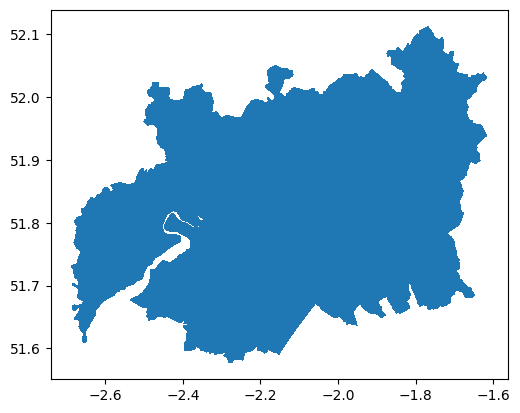

In [118]:
summarize_in_region("Gloucestershire")

In [140]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
MEMORY_KEY = "chat_history"
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful geospatial assistant, but don't know current events",
        ),
        MessagesPlaceholder(variable_name=MEMORY_KEY),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)


In [141]:
from langchain_community.tools.convert_to_openai import format_tool_to_openai_function

llm_with_tools = llm.bind(functions=[format_tool_to_openai_function(t) for t in tools])

In [142]:
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

chat_history = []

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
        "chat_history": lambda x: x["chat_history"],
    }
    | prompt
    | llm_with_tools
    | OpenAIFunctionsAgentOutputParser()
)

from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [150]:
result = agent_executor.invoke({"input": "Describe the difference between Walsall and Devon","chat_history": chat_history})
result["output"]



> Entering new AgentExecutor chain...

Invoking: `summarize_in_region` with `{'region': 'Walsall'}`


type,count
Open sprawl,99
Warehouse/Park land,80
Disconnected suburbia,67
Accessible suburbia,56
Connected residential neighbourhoods,55
Dense residential neighbourhoods,38
Urban buffer,29
Dense urban neighbourhoods,10
Local urbanity,10
Countryside agriculture,7
Gridded residential quarters,4

Invoking: `summarize_in_region` with `{'region': 'Devon'}`


type,count
Wild countryside,572
Countryside agriculture,274
Urban buffer,246
Open sprawl,245
Disconnected suburbia,145
Accessible suburbia,112
Warehouse/Park land,82
Dense residential neighbourhoods,82
Gridded residential quarters,50
Dense urban neighbourhoods,24
Local urbanity,19
Connected residential neighbourhoods,6
Regional urbanity,2
Metropolitan urbanity,1
The main difference between Walsall and Devon can be seen in the distribution of their spatial signatures. 

In Walsall, the most common spatial signature is "Open sprawl" wit

'The main difference between Walsall and Devon can be seen in the distribution of their spatial signatures. \n\nIn Walsall, the most common spatial signature is "Open sprawl" with a count of 99. This suggests that there is a significant amount of open and undeveloped land in Walsall. The next most common signature is "Warehouse/Park land" with a count of 80, indicating the presence of industrial or commercial areas. Other common signatures in Walsall include "Disconnected suburbia" (67), "Accessible suburbia" (56), and "Connected residential neighbourhoods" (55).\n\nOn the other hand, in Devon, the most common spatial signature is "Wild countryside" with a count of 572. This suggests that Devon has a large amount of natural and undeveloped countryside areas. The next most common signature is "Countryside agriculture" with a count of 274, indicating the presence of agricultural land. Other common signatures in Devon include "Urban buffer" (246), "Open sprawl" (245), and "Disconnected su

In [151]:
print(result["output"])

The main difference between Walsall and Devon can be seen in the distribution of their spatial signatures. 

In Walsall, the most common spatial signature is "Open sprawl" with a count of 99. This suggests that there is a significant amount of open and undeveloped land in Walsall. The next most common signature is "Warehouse/Park land" with a count of 80, indicating the presence of industrial or commercial areas. Other common signatures in Walsall include "Disconnected suburbia" (67), "Accessible suburbia" (56), and "Connected residential neighbourhoods" (55).

On the other hand, in Devon, the most common spatial signature is "Wild countryside" with a count of 572. This suggests that Devon has a large amount of natural and undeveloped countryside areas. The next most common signature is "Countryside agriculture" with a count of 274, indicating the presence of agricultural land. Other common signatures in Devon include "Urban buffer" (246), "Open sprawl" (245), and "Disconnected suburbi

In [149]:
result = agent_executor.invoke({"input": "Using the spatial signatures, answer the question, is Devon more Rural than Camden?","chat_history": chat_history})
result["output"]



> Entering new AgentExecutor chain...

Invoking: `summarize_in_region` with `{'region': 'Devon'}`


type,count
Wild countryside,572
Countryside agriculture,274
Urban buffer,246
Open sprawl,245
Disconnected suburbia,145
Accessible suburbia,112
Warehouse/Park land,82
Dense residential neighbourhoods,82
Gridded residential quarters,50
Dense urban neighbourhoods,24
Local urbanity,19
Connected residential neighbourhoods,6
Regional urbanity,2
Metropolitan urbanity,1

Invoking: `summarize_in_region` with `{'region': 'Camden'}`


type,count
Local urbanity,38
Dense urban neighbourhoods,14
Regional urbanity,7
Connected residential neighbourhoods,7
Warehouse/Park land,5
Dense residential neighbourhoods,3
Metropolitan urbanity,2
Concentrated urbanity,2
Hyper concentrated urbanity,1
Open sprawl,1
Based on the spatial signatures, Devon is more rural than Camden. Devon has a higher count of rural signatures such as "Wild countryside" and "Countryside agriculture" compared to Camden. Camden, on the 

'Based on the spatial signatures, Devon is more rural than Camden. Devon has a higher count of rural signatures such as "Wild countryside" and "Countryside agriculture" compared to Camden. Camden, on the other hand, has a higher count of urban signatures such as "Local urbanity" and "Dense urban neighbourhoods".'

In [67]:

agent_executor.invoke({"input": "how about the lest common", "chat_history":chat_history})



> Entering new AgentExecutor chain...

Invoking: `get_spatial_signature_list` with `{}`


type,count
Open sprawl,17357
Accessible suburbia,10919
Countryside agriculture,10882
Warehouse/Park land,10675
Urban buffer,10636
Disconnected suburbia,9418
Dense residential neighbourhoods,6815
Wild countryside,6214
Connected residential neighbourhoods,5802
Dense urban neighbourhoods,3344
Gridded residential quarters,2561
Local urbanity,1598
Regional urbanity,316
Metropolitan urbanity,135
outlier,15
Concentrated urbanity,11
Hyper concentrated urbanity,6
The least common spatial signature is "Hyper concentrated urbanity" with a count of 6.

> Finished chain.


{'input': 'how about the lest common',
 'chat_history': [],
 'output': 'The least common spatial signature is "Hyper concentrated urbanity" with a count of 6.'}